In [58]:
from cgitb import enable
from time import time
import numpy as np
import matplotlib.pyplot as plt
from vehicle import Vehicle

np.random.seed(0)   #For repeatability

num_states = 4
num_measurements = 2
num_iterations = 5000

position_update_freq = 100
timesteps = np.arange(0,num_iterations)

trajectory = np.empty((0,num_states), float)
ground_truth = np.empty((0,num_states), float)
NIS = np.empty((0,1), float)
NEES = np.empty((0,1), float)

#Initialize model
x0 = np.array([0,0,0,0])
P0 = 0.01*np.eye(num_states)
gt = x0

measurement_stds=np.array([0.1,0.1,0.0001,0.0002])
vehicle = Vehicle(x=x0, measurement_stds=measurement_stds)

u = np.vstack((num_iterations*[0.5], num_iterations*[0.5]))
#u = np.vstack(([0.01*np.cos(timesteps/10000)],[0.01*np.sin(timesteps/10000)]))

x_prev = x0
P_prev = P0

Q = np.diag([1e1,1e1,1e-5,2e-5])**2 # Best
Q = np.diag([1e3,1e3,1e-2,1e-2])**2 #Experimental
R = np.diag([3e-1,3e-1])**2 #Best
R = np.diag([1.5e-2,1.5e-2])**2 #Experimental

G = vehicle.G()

k = 0
while k <= num_iterations - 1:
    
    #Prediction step
    P_pred = vehicle.F(x_prev) @ P_prev @ vehicle.F(x_prev).T + Q
    x_pred = vehicle.f(x_prev, u[:,k])
    
    #Kalman gain and covariance
    S = G @ P_pred @ G.T + R    # Innovation covariance
    K = np.linalg.solve(S.T, (P_pred @ G.T).T).T   #Faster than P_pred @ G.T @ np.linalg.inv(G @ P_pred @ G.T + R)
    P = (np.eye(num_states) - K @ G) @ P_pred
    P_prev = P
    
    if (k % position_update_freq == 0):
        #Update step
        y = vehicle.g(x_prev, enable_noise=True)
        g = vehicle.g(x_pred, enable_noise=False)
        innovation = y - g
        x = x_pred + K @ innovation
        x_prev = x

        NIS = np.vstack((NIS, innovation.T @ np.linalg.solve(S, innovation)))
    else:
        x = x_pred
        x_prev = x

    #Store estimated trajectory
    trajectory = np.vstack((trajectory, x))

    #Store ground truth
    gt = vehicle.f(gt, u[:,k], enable_noise=False)
    ground_truth = np.vstack((ground_truth, gt))
    estimation_error = gt - x
    if k == 4900:
        print(estimation_error)
        print(P)
        print(innovation)
        print(S)

    NEES = np.vstack((NEES, estimation_error.T @ np.linalg.solve(P, estimation_error)))
    
    #Count iterations
    k+=1
ANIS = np.mean(NIS)
ANEES = np.mean(NEES)

[ 2.91298522e-01 -7.60478636e-01 -2.03152985e-05  3.88220999e-05]
[[ 8.99999918e-02  1.15173326e-16  6.51931523e-09  3.62890102e-10]
 [ 1.16212587e-16  8.99999919e-02  8.89052997e-09 -2.66102806e-10]
 [ 6.51931523e-09  8.89052995e-09  5.00085139e-01  9.37461828e-20]
 [ 3.62890102e-10 -2.66102806e-10  9.37508743e-20  5.00099958e-01]]
[-0.24233563  0.14768128]
[[1.00000019e+06 1.42877399e-02]
 [1.42877399e-02 1.00000020e+06]]


ANIS: 2.3451478438113213e-08
ANEES: 3.845590223358431


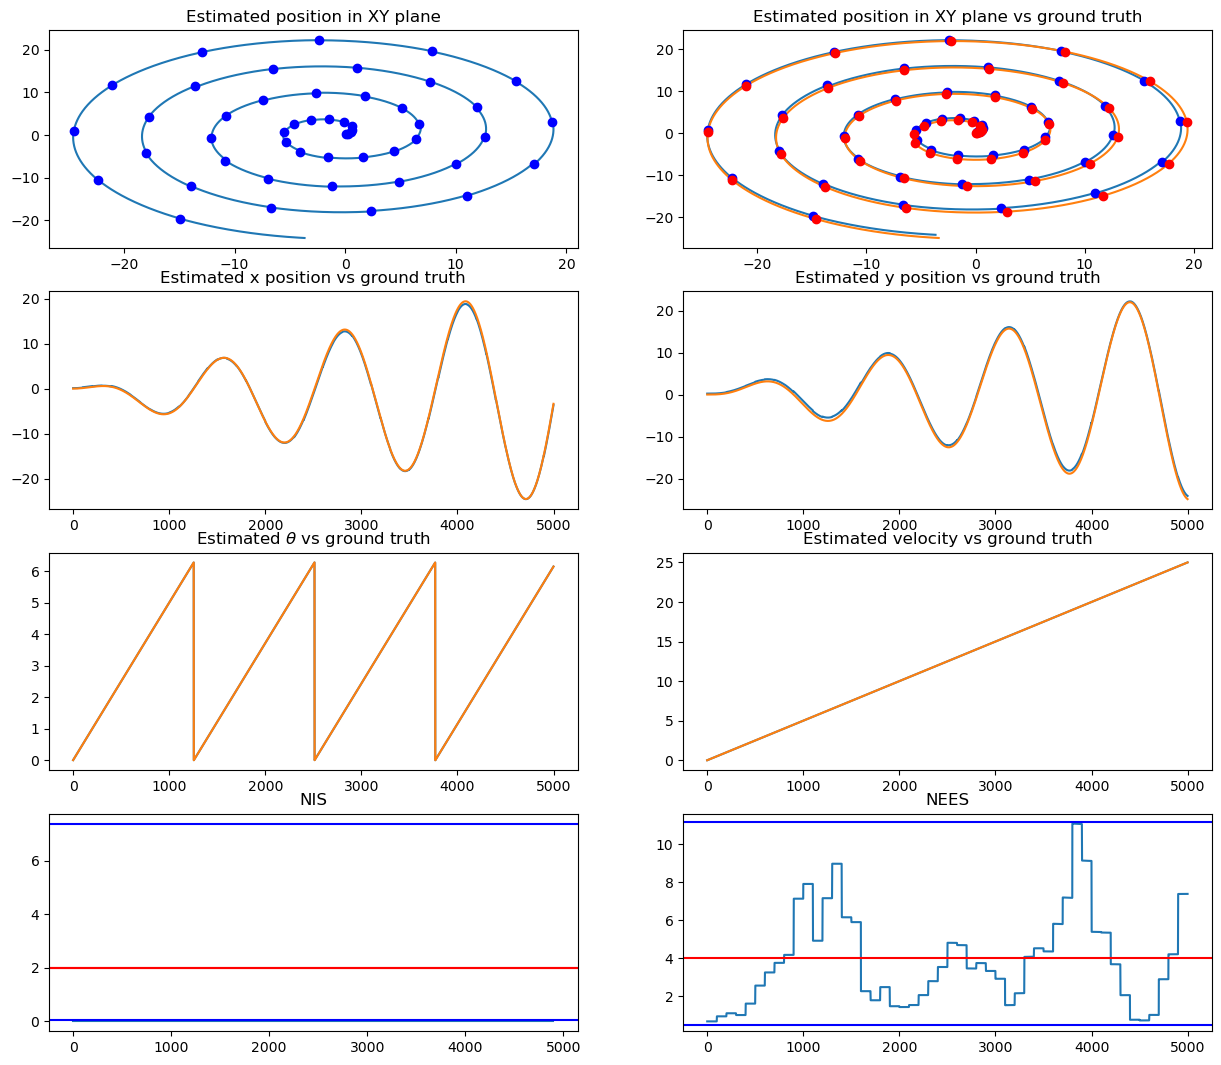

In [59]:
from scipy.stats.distributions import chi2

print(f"ANIS: {ANIS}\nANEES: {ANEES}")

confidence = 0.95
alpha = 1 - confidence
NEES_bounds = [chi2.ppf(alpha/2, df=num_states), chi2.ppf(1-alpha/2, df=num_states)]
NIS_bounds = [chi2.ppf(alpha/2, df=num_measurements), chi2.ppf(1-alpha/2, df=num_measurements)]

#Plotting
plt.rcParams['figure.figsize'] = [15, 13]
fig, axs = plt.subplots(4, 2)
axs[0,0].plot(trajectory[:,0], trajectory[:,1])
axs[0,0].plot(trajectory[::position_update_freq,0], trajectory[::position_update_freq,1], 'bo')
axs[0,0].set_title('Estimated position in XY plane')
axs[0,1].plot(trajectory[:,0], trajectory[:,1], ground_truth[:,0], ground_truth[:,1])
axs[0,1].plot(trajectory[::position_update_freq,0], trajectory[::position_update_freq,1], 'bo')
axs[0,1].plot(ground_truth[::position_update_freq,0], ground_truth[::position_update_freq,1], 'ro')
axs[0,1].set_title('Estimated position in XY plane vs ground truth')
states = ["x position","y position",r"$\theta$","velocity"]
for i in range(num_states):
    axs[1+i//2, i%2].plot(timesteps, trajectory[:,i], ground_truth[:,i])
    axs[1+i//2, i%2].set_title(f'Estimated {states[i]} vs ground truth')
axs[3,0].plot(timesteps[::position_update_freq], NIS[:,0])
axs[3,0].axhline(y = num_measurements, color = 'r', linestyle = '-')
axs[3,0].set_title('NIS')
axs[3,0].axhline(y = num_measurements, color = 'r', linestyle = '-')
[axs[3,0].axhline(y = i, color = 'b', linestyle = '-') for i in NIS_bounds]
axs[3,1].plot(timesteps, NEES[:,0])
axs[3,1].set_title('NEES')
axs[3,1].axhline(y = num_states, color = 'r', linestyle = '-')
[axs[3,1].axhline(y = i, color = 'b', linestyle = '-') for i in NEES_bounds]
pass